In [1]:
import pandas as pd

df = pd.read_csv('./simple-aug-data.csv')

texts = df['Title'].values
labels = df['Label'].values
print(texts)
print(labels)

['කොරෝනා වැලඳුණු ට්\u200dරම්ප් අද ජන රැලියක'
 'ආර්ථික විද්\u200dයාව පිළිබඳ නොබෙල් ත්\u200dයාගය ඇමරිකානුවන් දෙදෙනෙකුට'
 'ඉන්දියාවේ කොරෝනා ආසාදිතයන් 71 ලක්ෂය ඉක්මවයි' ...
 'හම්බන්තොට දෙවන අදියරත් කාර්යයක් අරඹයි'
 'ෆැසෙට්ස් අතීතාවර්ජනය සැප්තැම්බර් 3' 'කොටස් ගන්නොරුව ටිකක් ඉහළට']
['International' 'International' 'International' ... 'Business' 'Business'
 'Business']


In [2]:
stop_words = []

# Load your dataset
f = open("./stop words.txt", "r", encoding='utf-8')
for x in f:
    stop_words.append(x)

def remove_stopwords(texts, stopwords):
    filtered_texts = []
    for text in texts:
        # Tokenize the text into words
        words = text.split()
        # Remove stop words from the custom list (case insensitive)
        filtered_words = [word for word in words if word.lower() not in stopwords]
        # Join the words back into a filtered sentence
        filtered_texts.append(' '.join(filtered_words))
    return filtered_texts

# Remove stopwords from texts using the custom stopwords list
texts = remove_stopwords(texts, stop_words)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2211/2211 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.4761 - loss: 1.0196 - val_accuracy: 0.6499 - val_loss: 0.7787
Epoch 2/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.6570 - loss: 0.7745 - val_accuracy: 0.6858 - val_loss: 0.7077
Epoch 3/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - accuracy: 0.6918 - loss: 0.7127 - val_accuracy: 0.7057 - val_loss: 0.6715
Epoch 4/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - accuracy: 0.7161 - loss: 0.6765 - val_accuracy: 0.7145 - val_loss: 0.6551
Epoch 5/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.7253 - loss: 0.6517 - val_accuracy: 0.7234 - val_loss: 0.6398
Epoch 6/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - accuracy: 0.7366 - loss: 0.6346 - val_accuracy: 0.7184 - val_loss: 0.6429
Epoch 7/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.7452 - loss: 0.6159 - val_accuracy: 0.7279 - val_loss: 0.6330
Epoch 8/20
2211/2211 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - accuracy: 0.7503 - loss: 0.60

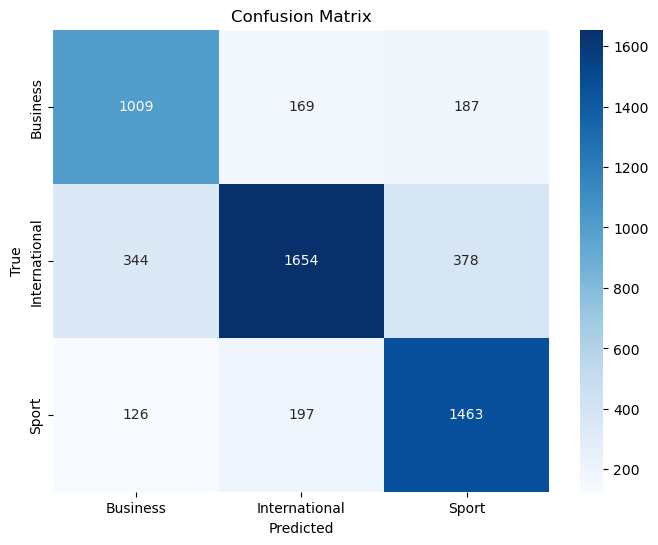


Classification Report:
                precision    recall  f1-score   support

     Business       0.68      0.74      0.71      1365
International       0.82      0.70      0.75      2376
        Sport       0.72      0.82      0.77      1786

     accuracy                           0.75      5527
    macro avg       0.74      0.75      0.74      5527
 weighted avg       0.75      0.75      0.75      5527

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Probabilities: [0.04530702 0.70330334 0.25138968]
Predicted Label: International


In [3]:
import fasttext
import tensorflow as tf
import pickle


import numpy as np
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

########################
tf.random.set_seed(42)

embedding_dim = 300  
max_vocab_size = 10000  
max_sequence_length = 20  


label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)

categorical_labels = to_categorical(integer_encoded_labels)


tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, categorical_labels,test_size=0.2,stratify=categorical_labels, random_state=42)


ft_model = fasttext.load_model('./cc.si.300.bin')  

word_vectors = {word: ft_model.get_word_vector(word) for word in set(texts)} 
embedding_matrix = np.zeros((len(word_vectors) + 1, embedding_dim))
word_index = {word: i + 1 for i, word in enumerate(word_vectors.keys())}
for word, i in word_index.items():
    embedding_matrix[i] = word_vectors[word]


model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_sequence_length,
              trainable=False),  
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  
])


model.compile(loss='categorical_crossentropy',  # For multiclass classification
              optimizer='adam',
              metrics=['accuracy'])


model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


def preprocess_and_predict_multiclass(text, tokenizer, model, max_sequence_length, label_encoder):
    
    sequence = tokenizer.texts_to_sequences([text])
    
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    
    prediction = model.predict(padded_sequence)[0]
    
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
    return prediction, predicted_class_label


new_text = "කොරෝනා වැලඳුණු ට්‍රම්ප් අද ජන රැලියක"


probabilities, predicted_label = preprocess_and_predict_multiclass(new_text, tokenizer, model, max_sequence_length, label_encoder)

print(f"Predicted Probabilities: {probabilities}")
print(f"Predicted Label: {predicted_label}")

# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(label_encoder, f)

# model.save("model.h5")  # Saving in HDF5 format

